<a href="https://colab.research.google.com/github/oopsys6/FACE_MASK-Detection/blob/main/Ch3_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Augmentation

인기 있는 데이터셋의 경우 수천 수만장의 이미지를 가지고 있습니다. 하지만 모든 데이터셋이 그렇진 못합니다.  그러면 제한된 데이터셋을 학습 시키기 위해서는 어떻게 해결 해야 할까요?

우리는 데이터셋이 부족하다고 새로운 이미지를 찾을 필요가 없습니다. 왜냐하면 Data Augmentation을 이용하여 다양한 상태의 이미지를 얻을 수 있기 때문입니다.

![](https://drive.google.com/uc?id=1ammM-EnG9aCvMsLvpm-P-6UvOz56M9P3)
- 그림 3.1 같아 보이지만 다른 테니스 공 (출처:https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/)

그림 3.1은 사람이 보기엔 다 똑같은 테니스 공입니다. 하지만 신경망은 3개의 테니스 공을 다 다르게 봅니다. 이와 같은 원리로 우리는 하나의 사진을 변조 시켜 여러 개의 데이터를 추출해낼 수 있습니다.

Augmentation를 처리하기 위해서 Albumentations를 사용해 볼 것입니다. Albumentations는 OpenCV와 같은 오픈 소스 컴퓨터 비젼 라이브러리를 최적화 하였기에 다른 image argumentation 라이브러리보다 더 빠른 처리 속도를 보여주고 다양한 기능도 제공합니다. 

우선 많이 사용하는 pytorchvison.transforms와 albumentations을 비교하여 albumentations가 얼마나 빠른지에 대해 알아봅시다.




우선 튜토리얼에서 사용할 모듈들을 import 해주겠습니다.

In [ ]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt

from google.colab import drive

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


TorchvisionDataset 클래스는 __getitem__ 함수를 통해 image를 불러온 다음 transform을 적용하고 시간 측정을 위해 time함수를 사용하여 image, label, total_time을 반환해줍니다.

In [ ]:
class TorchvisionDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with PIL
        image = Image.open(file_path)
        
        start_t = time.time()
        if self.transform:
            image = self.transform(image)
        total_time = (time.time() - start_t)

        return image, label, total_time

trainsforms을 사용하여 이미지를 (256, 256)으로 resize 시키고, RandomCrop을 사용하여 이미지를 224로 자릅니다. 이후 HorizontalFlip을 적용시킨 후 ToTensor로 변환하는 작업을 진행합니다. 

In [ ]:
torchvision_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

torchvision_dataset = TorchvisionDataset(
    file_paths=["/content/gdrive/My Drive/maskData.png"],
    labels=[1],
    transform=torchvision_transform,
)

torchvision_dataset에서 transform에 소요된 시간을 계산하고 그것을 100번 반복한 시간을 측정합니다. 그리고 transform이 적용된 사진도 함께 보여줄 수 있는 코드를 작성하였습니다.

torchvision time: 30.257673263549805 ms


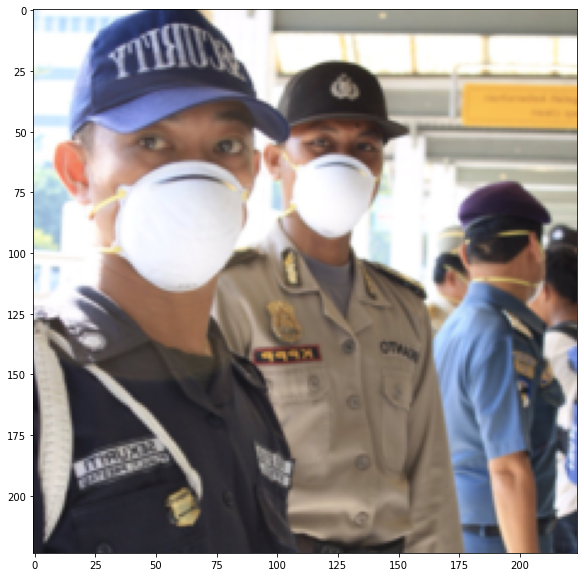

In [ ]:
total_time = 0
for i in range(100):
  sample, _, transform_time = torchvision_dataset[0]
  total_time += transform_time

print("torchvision time: {} ms".format(total_time*10))

plt.figure(figsize=(10, 10))
plt.imshow(transforms.ToPILImage()(sample))
plt.show()

AlbumentationDataset은 TorchVisionDataset과 비슷한 구조를 가지고 있습니다.
cv2 모듈을 사용하여 이미지를 불러드리고 RGB로 바꿔줍니다.

In [ ]:
class AlbumentationsDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with OpenCV
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            total_time = (time.time() - start_t)
        return image, label, total_time

torchvision_transform과 같이 rezie, crop, horizontalFlip, ToTensor를 진행합니다.

In [ ]:
# Same transform with torchvision_transform
albumentations_transform = albumentations.Compose([
    albumentations.Resize(256, 256), 
    albumentations.RandomCrop(224, 224),
    albumentations.HorizontalFlip(), 
    albumentations.pytorch.transforms.ToTensor()
])

이후 transform을 100번 적용 시킨 뒤 시간을 측정하였습니다.


albumentations time/sample: 1.923823356628418 ms


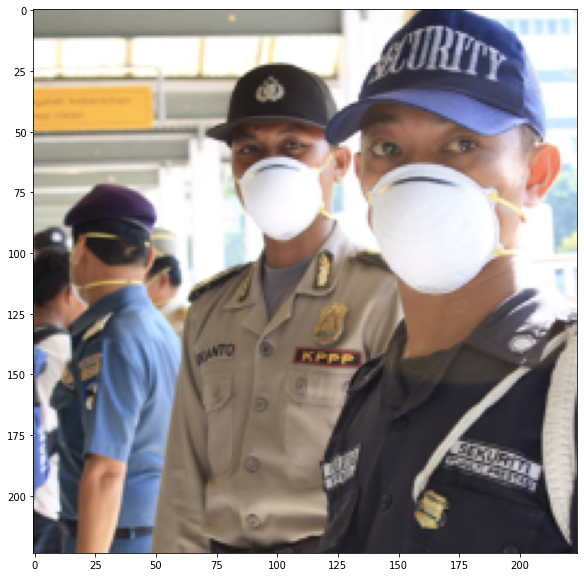

In [ ]:
# Same dataset with torchvision_dataset
albumentations_dataset = AlbumentationsDataset(
    file_paths=["/content/gdrive/My Drive/maskData.png"],
    labels=[1],
    transform=albumentations_transform,
)
total_time = 0
for i in range(100):
    sample, _, transform_time = albumentations_dataset[0]
    total_time += transform_time

print("albumentations time/sample: {} ms".format(total_time*10))

plt.figure(figsize=(10, 10))
plt.imshow(transforms.ToPILImage()(sample))
plt.show()

Torchvision.transforms 보다 albumentation의 속도가 30배 가까이 차이가 나는 것을 확인할 수 있었습니다.

아래의 코드를 보게 되면 OneOf 함수가 있습니다. 이 함수는 list 안에 있는 값을 랜덤하게 가져옵니다. 또는 list 값 자체에 확률을 부여할 수도 있습니다. 아래의 OneOf 함수 안의 리스트를 보게 되면 p=1인 데이터가 3개이기 때문에 1/3의 확률인 것을 알 수 있습니다.

In [ ]:
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(256, 256), 
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.pytorch.ToTensor()
])

아래는 albumentations_transform_oneof가 적용된 이미지 10번 적용한 결과입니다.

Image Augmentation이 잘 적용된 것을 확인할 수 있습니다.

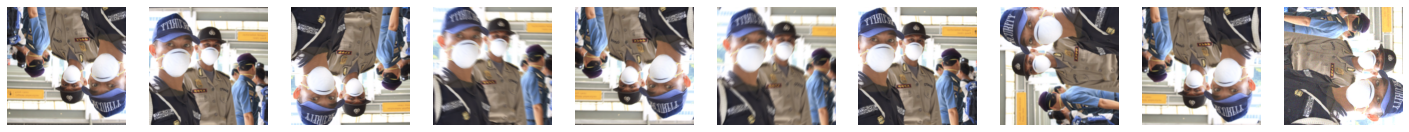

In [ ]:
albumentations_dataset = AlbumentationsDataset(
    file_paths=["/content/gdrive/My Drive/maskData.png"],
    labels=[1],
    transform=albumentations_transform_oneof,
)

num_samples = 10
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(albumentations_dataset[0][0]))
  ax[i].axis('off')